In [2]:
import json
import bz2
import sys
import os
import numpy as np
import pandas as pd
import networkx as nx
import networkx.algorithms.community as community
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy.stats import spearmanr
from chart_studio import plotly
from plotly.offline import iplot
import plotly.graph_objs as go
from sklearn import preprocessing
#from utils import plotly_graph

defining plotting function:

In [3]:
def plotly_graph(g,Layout,labels,parties='grey',colormap='white',centrality=10):
    #normalize all weights.
    Xv=[Layout[k][0] for k in list(g.nodes())]
    Yv=[Layout[k][1] for k in list(g.nodes())]
    Xe=[]
    Ye=[]
    for e in g.edges():
        Xe+=[[Layout[e[0]][0],Layout[e[1]][0],None]]
        Ye+=[[Layout[e[0]][1],Layout[e[1]][1],None]]
    scatters=[]
    for i in range(len(g.edges())):
        if list(nx.get_edge_attributes(g,'weight').values())[i] > 10:
            scatters.append(go.Scatter(x=Xe[i],y=Ye[i],mode='lines',
                        line=dict( 
                                shape='spline',
                                width=list(nx.get_edge_attributes(g,'weight').values())[i]**.2,
                                color='mediumaquamarine'),
                        ))
    scatters.append(go.Scatter(x=Xv,y=Yv,mode='markers',
            marker=dict(
                color=parties,
                size=[np.sqrt(i*50000) for i in centrality], #[np.sqrt(value*10000) for value in centrality],
                opacity=1,
                line=dict(
                    color=colormap,
                    width=[np.sqrt(i*250) for i in centrality],#[np.sqrt(int(value*100)) for value in centrality]
                )),
            hovertemplate=labels
             ))
    axis=dict(showbackground=False,
            showline=False,
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            title='',
            visible=False
            )
    layout = go.Layout(
            width=1000,
            height=1000,
            showlegend=False,
            scene=dict(
                xaxis=dict(axis),
                yaxis=dict(axis),
            ),
        margin=dict(
            t=100
        ),
        hoverdistance=1,
        #hovermode='closest',
        paper_bgcolor='rgba(255,255,255,255)',
        plot_bgcolor='rgba(0,0,0,0)',
            )
    fig=go.Figure(data=scatters,layout=layout)
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    iplot(fig)

def scaler(list):
    return [i/sum(list) for i in list]

loading catalogue and usa policitians mentions:

In [4]:
np.random.seed(4812)
quotes_mapped='quotes_mentions_USA_ML_bias.json.bz2'
WIKI_DATA_FILTERED='filtered_politician_labeled_us_v3.json.bz2'

df_full=pd.read_json(quotes_mapped, lines=True)
catalogue_df=pd.read_json(WIKI_DATA_FILTERED, lines=True)
print(df_full.shape)
df_full.head()

(450436, 14)


,quoteID,quotation,speaker,qids,date,numOccurrences,phase,mentions,mentions_qids,urls,topic_index,topic_scores,sentiment,source_bias
0,2015-10-25-000242,"' It is not now, nor has it ever been, the gol...",Bernie Sanders,Q359442,2015-10-25 14:12:35,1,E,[Bill Clinton],[Q1124],[examiner.com],8,0.818588,-0.4822,0.1168
1,2015-08-07-005048,All we ╒ re asking for here is a discussion an...,John Boehner,Q11702,2015-08-07 12:52:52,1,E,[Barack Obama],[Q76],[liveblog.irishtimes.com],8,0.774811,0.0000,NaN
2,2015-10-01-005722,An email included in the latest tranche of Cli...,Hillary Clinton,Q6294,2015-10-01 14:56:48,2,E,[Bill Clinton],[Q1124],"[feeds.foxnews.com, www.foxnews.com]",4,0.368826,-0.2732,0.7295
3,2015-11-17-006368,"and in fact, Secretary of State Kerry was earl...",Phil Bryant,Q887898,2015-11-17 20:03:05,1,E,[John Kerry],[Q22316],[hottytoddy.com],1,0.774721,0.0258,NaN
4,2015-02-14-014011,I have fought Obamacare from Day One and will ...,John Cornyn,Q719568,2015-02-14 21:01:51,2,E,[Barack Obama],[Q76],"[www.politico.com, politico.com]",2,0.389230,-0.1280,-0.1914


selecting only the main democratic and republicans parties (with more than 10 politicians in the catalogue, may need to filter more to be more exhaustive?) (for each one checked on wikipedia if "affiliated to national Democratic/Republican party"). Keeping only the first party from the catalogue parties list, not sure about this.

In [5]:
#execute only once
catalogue_df.parties = catalogue_df.parties.apply(lambda x: x[0] if len(x)>0 else '')
catalogue_df['parties'][catalogue_df.parties.str.contains('Republican')]='Republican Party'
catalogue_df['parties'][catalogue_df.parties.str.contains('Democratic')]='Democratic Party'
catalogue_df=catalogue_df[catalogue_df.parties.str.contains('Democratic|Republican')] #keep only republican and democrate parties and affiliates

create men_df, dataframe of single mentions where the mentioneer and mentioned politicians are in the catalogue. filtering out self-mentions:

In [18]:
source_bias_range=[-.5,-.25]
df=df_full#[['qids','mentions_qids','speaker']]
#df=df.loc[:100000,:] # uncomment this to compute the network on less data
men_df=pd.DataFrame()
for i,row in df.iterrows():
    if source_bias_range[0] <= row.source_bias <= source_bias_range[1]:
        if row.qids in catalogue_df.qid.values:
            for mention_qid in row.mentions_qids:
                if (mention_qid in catalogue_df.qid.values) & (row.qids != mention_qid):
                    mention=pd.Series([row.qids,mention_qid,row.speaker])
                    men_df=men_df.append(mention,ignore_index=True)
    if i%10000==0: print(i)
men_df.rename(columns={0:'qid',1:'mention_qid',2:'speaker'},inplace=True)
print(men_df.head())
print(f'men_df shape {men_df.shape}')

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
        qid mention_qid                 speaker
0   Q547218    Q1135774            Mike Coffman
1   Q971308     Q538868              Pat Toomey
2  Q5562913    Q5218111           Gina Raimondo
3       Q76   Q22003929  President Barack Obama
4  Q1686078        Q207             Jeb Bradley
men_df shape (41627, 3)


create the adjacency table:

In [19]:
adj_df = pd.crosstab(men_df.qid, men_df.mention_qid)
idx = adj_df.columns.union(adj_df.index)
adj_df = adj_df.reindex(index = idx, columns=idx, fill_value=0)
adj=adj_df.values
print(f'number of politicians in network: {len(adj_df.index)}')

number of politicians in network: 2897


build graph from adjacency matrix:

In [20]:
g=nx.from_numpy_matrix(adj,create_using=nx.DiGraph)
g=nx.relabel_nodes(g,mapping=lambda x: adj_df.index[x])
#L=nx.kamada_kawai_layout(g)
labels=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in g.nodes()]
len(labels) #check if matches with network nodes number

2897

basic network analysis

C:\Users\totol\anaconda3\envs\ADA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



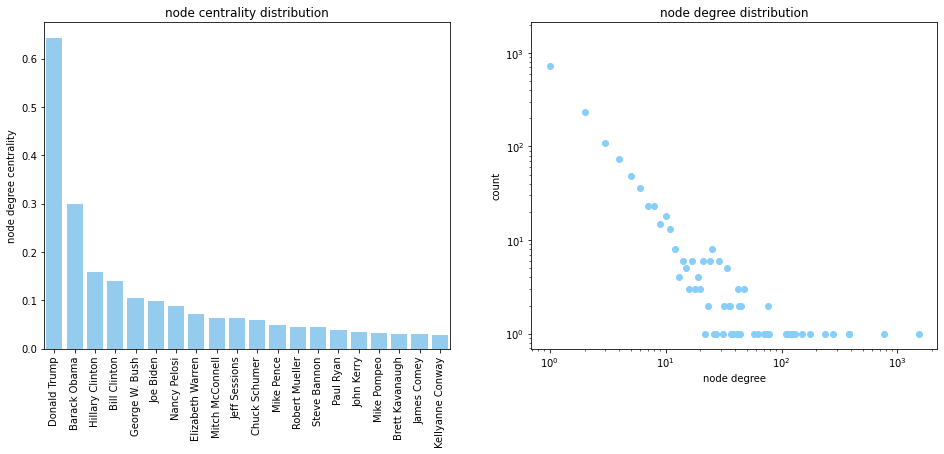

In [21]:
in_degrees = dict(g.in_degree())
in_values = sorted(in_degrees.values())
in_hist = Counter(in_degrees.values())

centr=nx.degree_centrality(g)
sorted_centr=sorted(centr.items(), key=lambda x: x[1], reverse=True)[:20]
names=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in [x[0] for x in sorted_centr]]

fig,axs=plt.subplots(1,2,figsize=(16,6))
axs[0].set_title('node centrality distribution')
sns.barplot(names,[x[1] for x in sorted_centr], color='LightSkyBlue',ax=axs[0])
axs[0].tick_params('x',labelrotation = 90)
axs[0].set_ylabel('node degree centrality')

axs[1].set_title('node degree distribution')
axs[1].scatter([x for x in in_hist], [in_hist[x] for x in in_hist], color='LightSkyBlue')
axs[1].set_xscale('log')
axs[1].set_xlabel('node degree')
axs[1].set_yscale('log')
axs[1].set_ylabel('count')
plt.show()

compute kernighan_lin_bisection of the graph. Uses only undirected graph but for communities doesn't matter. [paper link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6771089)

In [22]:
communities=community.kernighan_lin_bisection(g.to_undirected(),seed=42)
g0=g.subgraph(communities[0])
centr0=nx.degree_centrality(g0)
sorted_centr0_nodes=[x[0] for x in sorted(centr0.items(), key=lambda x: x[1], reverse=True)[:20]]

g1=g.subgraph(communities[1])
centr1=nx.degree_centrality(g1)
sorted_centr1_nodes=[x[0] for x in sorted(centr1.items(), key=lambda x: x[1], reverse=True)[:20]]

sorted_center_nodes=[]
sorted_center_nodes.extend(sorted_centr0_nodes)
sorted_center_nodes.extend(sorted_centr1_nodes)
g_centers=g.subgraph(sorted_center_nodes)
Laycentr=nx.kamada_kawai_layout(g_centers)
labels_centr=[catalogue_df.loc[catalogue_df.qid == qid, 'name'].item() for qid in g_centers.nodes()]
party_centr=[catalogue_df.loc[catalogue_df.qid == qid, 'parties'].item() for qid in g_centers.nodes()]
party_col_centr=['tomato' if x=='Republican Party' else 'dodgerblue' for x in party_centr]
colors=['darkgreen','gold']
colmap_centr=['black']*nx.number_of_nodes(g_centers)
counter=0
for i,n in enumerate(sorted_centr0_nodes):
    colmap_centr[i]=colors[0]
for i,n in enumerate(sorted_centr1_nodes):
    colmap_centr[i+len(sorted_centr0_nodes)]=colors[1]

centrality=scaler([centr[qid] for qid in g_centers.nodes()])

compute catalogue keeping only qids in network, and setting binary_party and binary_community columns:

In [23]:
catalogue_graph=catalogue_df.loc[catalogue_df.qid.isin(list(g.nodes))].copy()
catalogue_graph.reset_index(drop=True, inplace=True)
catalogue_graph['binary_party'] = np.where(catalogue_graph.parties.loc[:] == 'Democratic Party',1,0)
catalogue_graph['binary_community'] = np.where(catalogue_graph.qid.isin(list(g0.nodes)),1,0)
catalogue_graph.head()

,qid,name,gender,nationality,aliases,parties,positions held,religion,us_congress_id,candidacy_election,State,binary_party,binary_community
0,Q207,George W. Bush,male,Q30,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",Republican Party,"[[Governor of Texas, [+1995-01-17T00:00:00Z]],...",Q329646,,"[2000 United States presidential election, 200...",Texas,0,0
1,Q4496,Mitt Romney,male,Q30,"[Willard Mitt Romney, Pierre Delecto]",Republican Party,"[[Governor of Massachusetts, [+2003-01-02T00:0...",Q42504,R000615,"[2012 Republican Party presidential primaries,...",Massachusetts,0,0
2,Q11124,Stephen Breyer,male,Q30,[Stephen Gerald Breyer],Democratic Party,[[Associate Justice of the Supreme Court of th...,Q9268,,[],None,1,0
3,Q22201,Jim DeMint,male,Q30,"[James Warren ""Jim"" DeMint, James Warren DeMint]",Republican Party,"[[United States representative, []], [United S...",Q178169,D000595,[],None,0,0
4,Q22290,Olympia Snowe,female,Q30,"[Olympia J. Snowe, Olympia Bouchles, Olympia J...",Republican Party,"[[United States representative, [+1979-01-03T0...",Q3333484,S000663,[],None,0,1


compute Spearman correlation coefficient and pval. Spearman correlation makes sense here because we want to capture if the 2 variables are correlated or anti-correlated, because we don't control wether which binary value will be applied to which community (all same => Spearman coeff=1, all contrary => Spearman coeff=-1 and we take the absolute value). We don't want to just check similarity because it doesn't capture anti-correlation. [wikipedia link](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). Using two-sided t test with a 95% confidence interval.

In [24]:
spearman_corr,spearman_pval=spearmanr(catalogue_graph.binary_party,catalogue_graph.binary_community)
abs_spearman_corr = np.abs(spearman_corr)
print(f'absolute value of Spearman correlation coefficient = {round(abs_spearman_corr,4)}, with a p-value of {round(spearman_pval,4)}')
if spearman_pval < .025:
    print(f'spearman correlation of coefficient = {round(spearman_pval,4)} < 0.025, so there is a statististically significant correlation between the graph bisection and real politicians parties.')
else:
    print(f'spearman correlation of coefficient = {round(spearman_pval,4)} > 0.025, so there is no statististically significant correlation between the two network communities and real politicians parties.')

absolute value of Spearman correlation coefficient = 0.0323, with a p-value of 0.0823
spearman correlation of coefficient = 0.0823 > 0.025, so there is no statististically significant correlation between the two network communities and real politicians parties.


plotting 20 most central nodes of each communities together:

In [25]:
plotly_graph(g_centers,Laycentr,labels_centr,party_col_centr,colmap_centr,centrality)